# Results

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../../..')

## 0. Load model and data

Let us load some data from the validation set

In [2]:
from os import listdir

# Paths where data is stored
dataset_dir = '/root/fs9/lucas/data/datasets/year_256/'
chunk_filenames = listdir(dataset_dir)
valid_chunk_filenames = chunk_filenames[27:35]

In [3]:
from pyphoon.app.utils import load_h5datachunks

X_valid, Y_valid, idx_valid, seqno_valid = load_h5datachunks(dataset_dir,
                                                             valid_chunk_filenames, 
                                                             features=['data', 'pressure', 'idx', 'seq_no'],
                                                             ignore_classes=[6, 7],
                                                             verbose=True
                                                            )

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


 file chunk_27.h5 read
 file chunk_28.h5 read
 file chunk_29.h5 read
 file chunk_30.h5 read
 file chunk_31.h5 read
 file chunk_32.h5 read
 file chunk_33.h5 read
 file chunk_34.h5 read


Next, we load the model by using module `pyphoon.models.tc_pressure_regression`, which provides the network architecture and corresponding data preprocessor.

In [4]:
from pyphoon.models.tc_pressure_regression import tcRegNet, tcRegPreprocessor

model = tcRegNet('../weights.hdf5')
preprocessor = tcRegPreprocessor()

## 1. Kernels first layer
An interesting thing to observe are the kernel weights in the first layer. These kernels are in charge of scanning the input images and detecting certain patterns. Ideally, all kernels should show distinct features. Appearance of similar kernels may indicate that we are using too many kernels. Also, kernels with near-zero values may indicate dead units, a phenomenon that often happens when using ReLU activation.

In [5]:
# Get all weights
weights = {}
for layer in model.layers:
    weights[layer.name] = layer.get_weights()

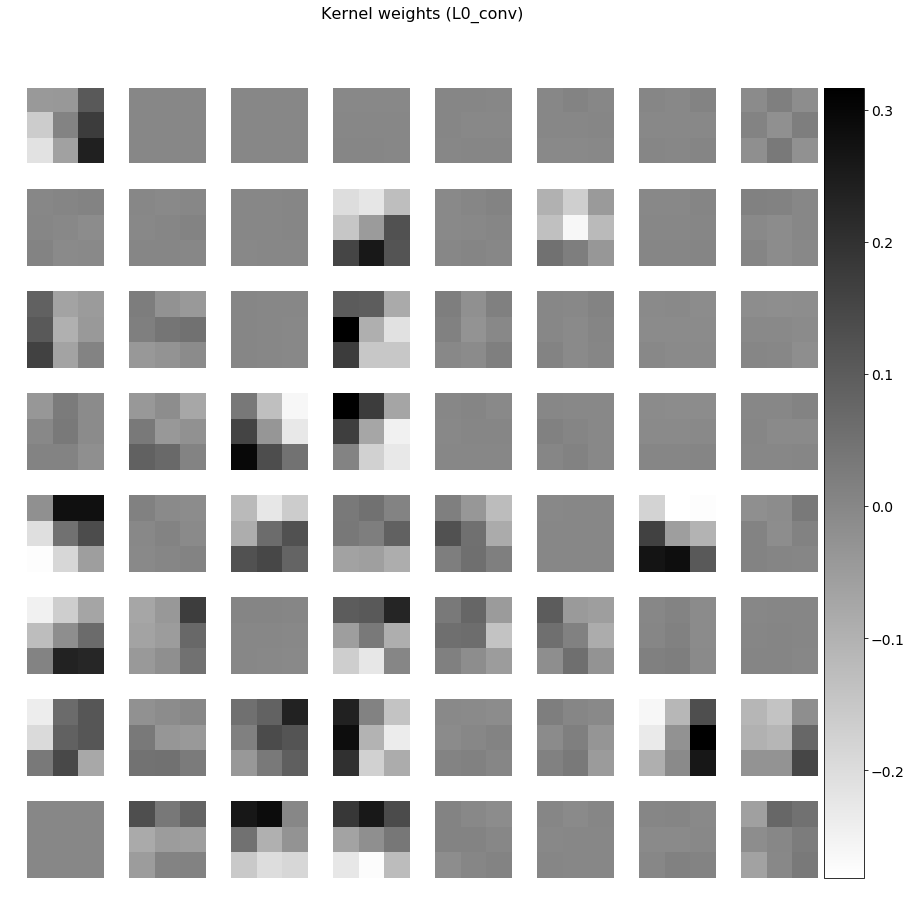

In [7]:
from pyphoon.app.explore import good_shape_conv_weights
from pyphoon.visualise import nice_imshow, make_mosaic
import matplotlib.cm as cm
import matplotlib.pyplot as plt

W = good_shape_conv_weights(weights['conv2d_1'])
plt.figure(figsize=(15, 15))
plt.title('Kernel weights (L0_conv)', fontsize=16, y=1.08)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(W[:,:,:,0], 8, 8), cmap=cm.binary, colorbar=True, barsize=14)
#plt.savefig('../_assets/weights_tcxtc.eps', format='eps')

## 2. Network activations
An artificial neural network may be regarded as a black box. To mitigate this feeling, in this section we look at the activation maps throughout the different network layers for a particular input image. We will use an image from sequence `200003`, which depicts a tropical cyclone of intensity 5.

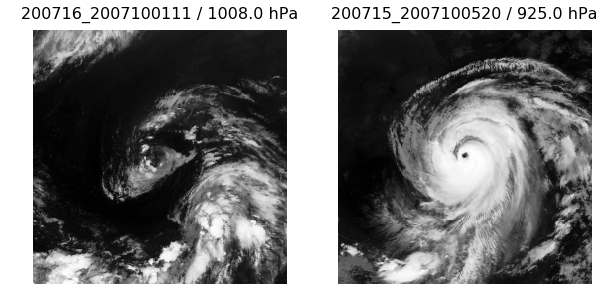

In [14]:
from pyphoon.io.h5 import read_source_image
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

chunk = 2
idx = 185
X1 = X_valid[chunk][idx]
title1 = idx_valid[chunk][idx].decode("utf-8") + " / " + str(Y_valid[chunk][idx]) + " hPa"

chunk = 2
idx = 110
X2 = X_valid[chunk][idx]
title2 = idx_valid[chunk][idx].decode("utf-8") + " / " + str(Y_valid[chunk][idx]) + " hPa"

# Plot
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(X1, 'Greys')
plt.axis('off')
plt.title(title1, fontsize=16, y=1.02)
plt.subplot(1,2,2)
plt.imshow(X2, 'Greys')
plt.axis('off')
plt.title(title2, fontsize=16, y=1.02)
plt.show()

In [15]:
import cv2

def prepare_image(X):
    # Resize image to 256x256 and add axis 0 (required for preprocessor)
    X = np.expand_dims(cv2.resize(X, (256,256)), 0)
    # Preprocess
    X = preprocessor.apply(X)
    # Crop
    X = X[:, 64:64+128, 64:64+128, :]
    
    return X

X1 = prepare_image(X1)
X2 = prepare_image(X2)

### 2.1 Convolutional Layers
Let us commence with the visualisation of the feature maps in the first three layers, which are convolutional.

In [24]:
from pyphoon.app.explore import get_activations

def plot_conv_layers(X):
    C = get_activations(model, 'max_pooling2d_1', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L0_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 8, 8), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    # plt.savefig('../_assets/example_activation_l0_tc.eps', format='eps')

    C = get_activations(model, 'max_pooling2d_2', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L1_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 12, 12), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    # plt.savefig('../_assets/example_activation_l1_tc.eps', format='eps')

    C = get_activations(model, 'max_pooling2d_3', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L2_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 12, 12), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    # plt.savefig('../_assets/example_activation_l1_tc.eps', format='eps')

    C = get_activations(model, 'max_pooling2d_4', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L3_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 16, 16), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    # plt.savefig('../_assets/example_activation_l1_tc.eps', format='eps')

    C = get_activations(model, 'max_pooling2d_5', X)
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L4_mp', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 16, 16), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    # plt.savefig('../_assets/example_activation_l1_tc.eps', format='eps')

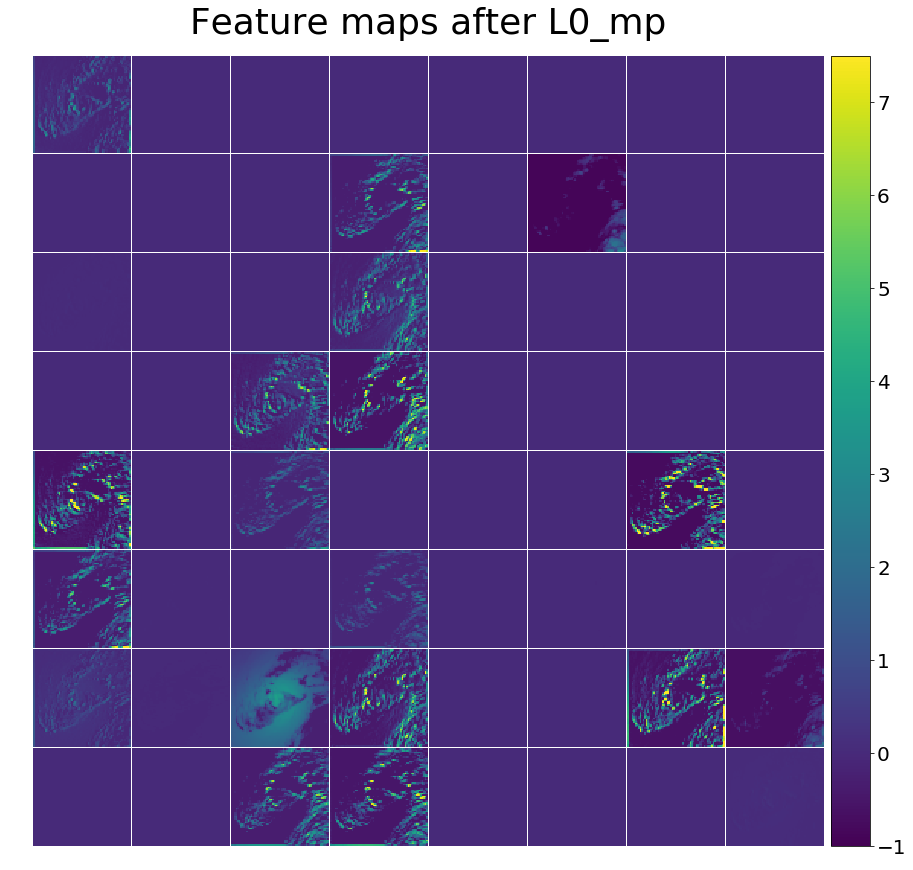

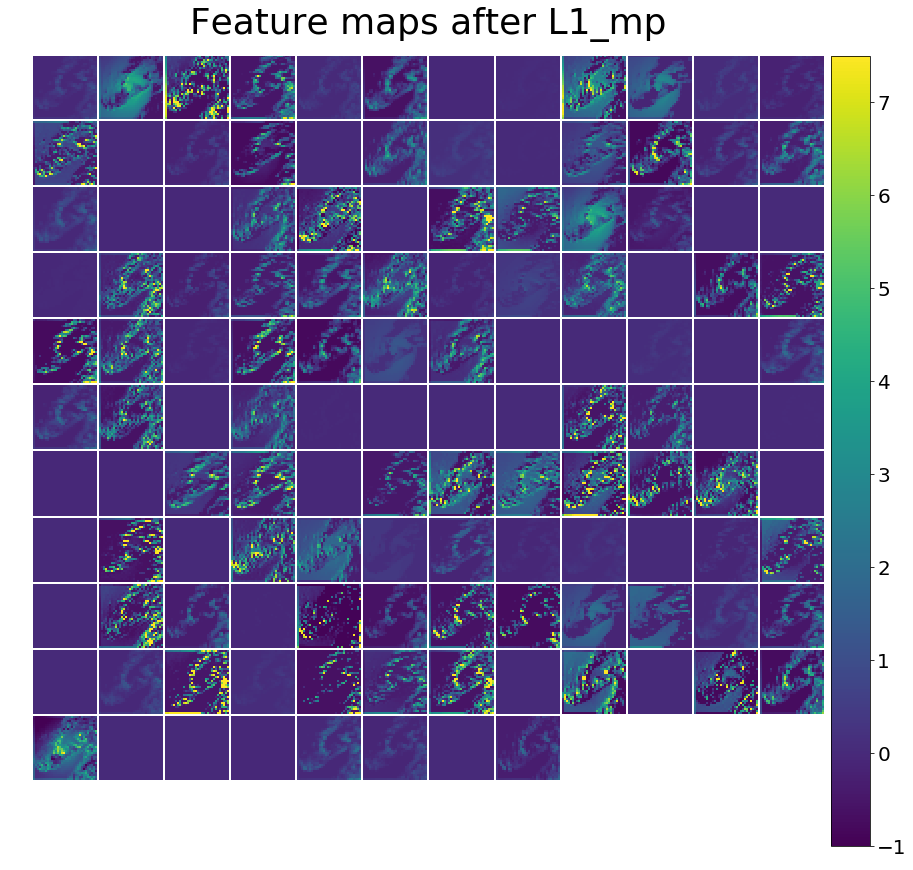

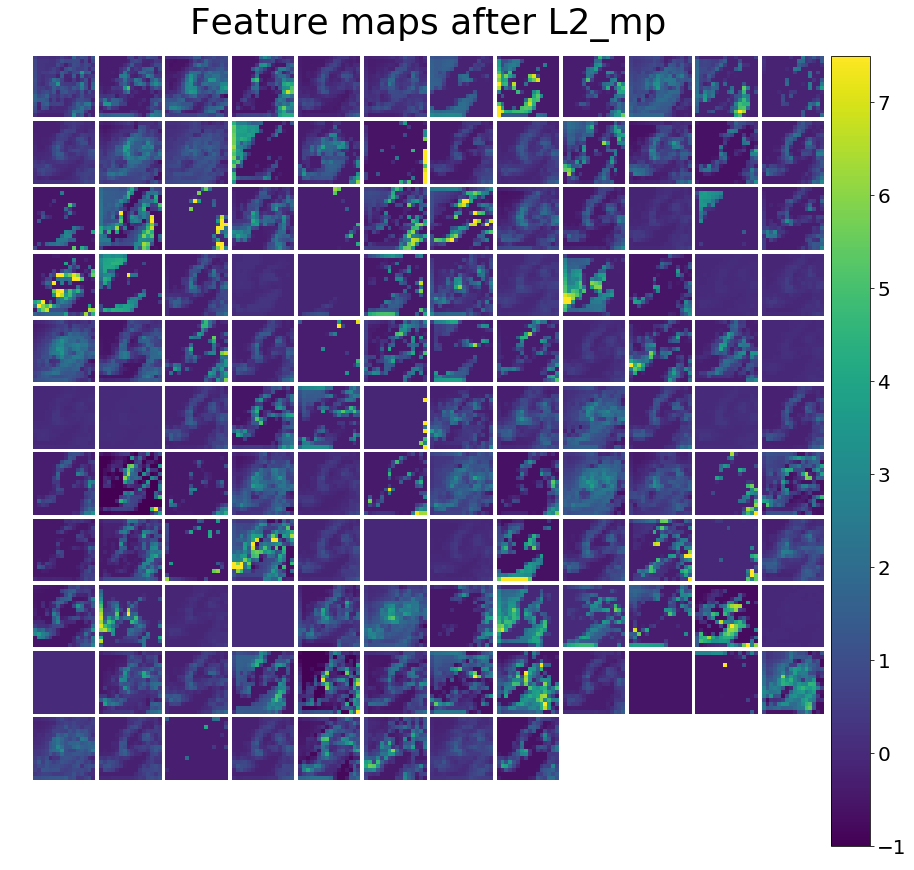

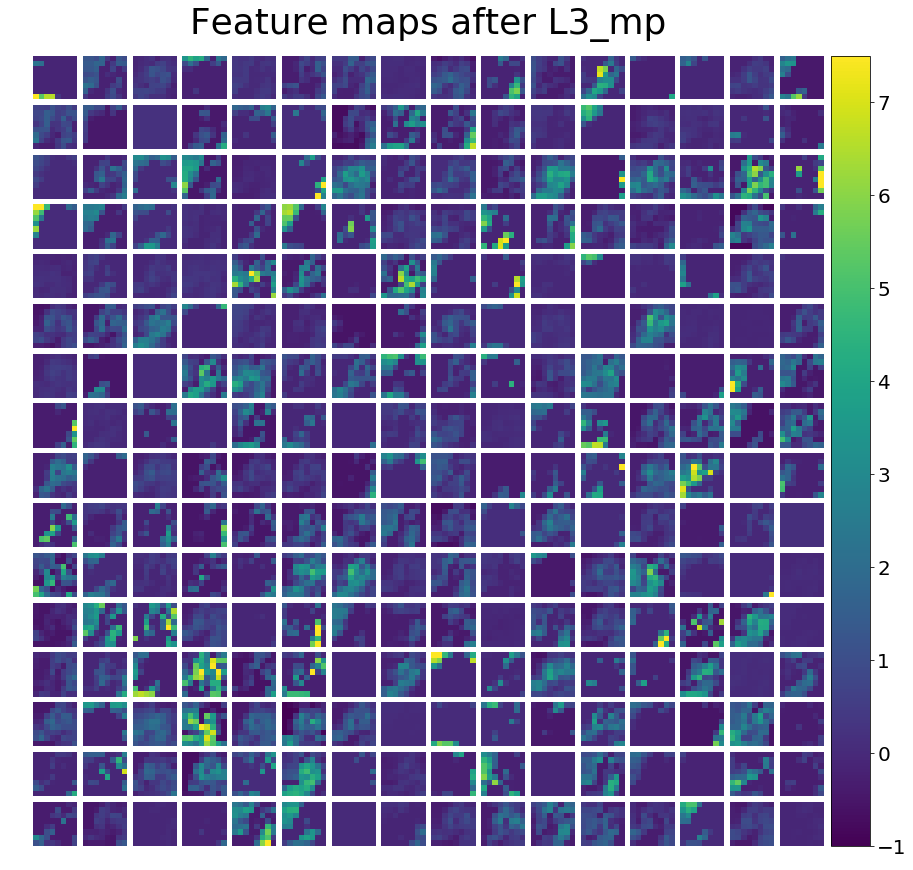

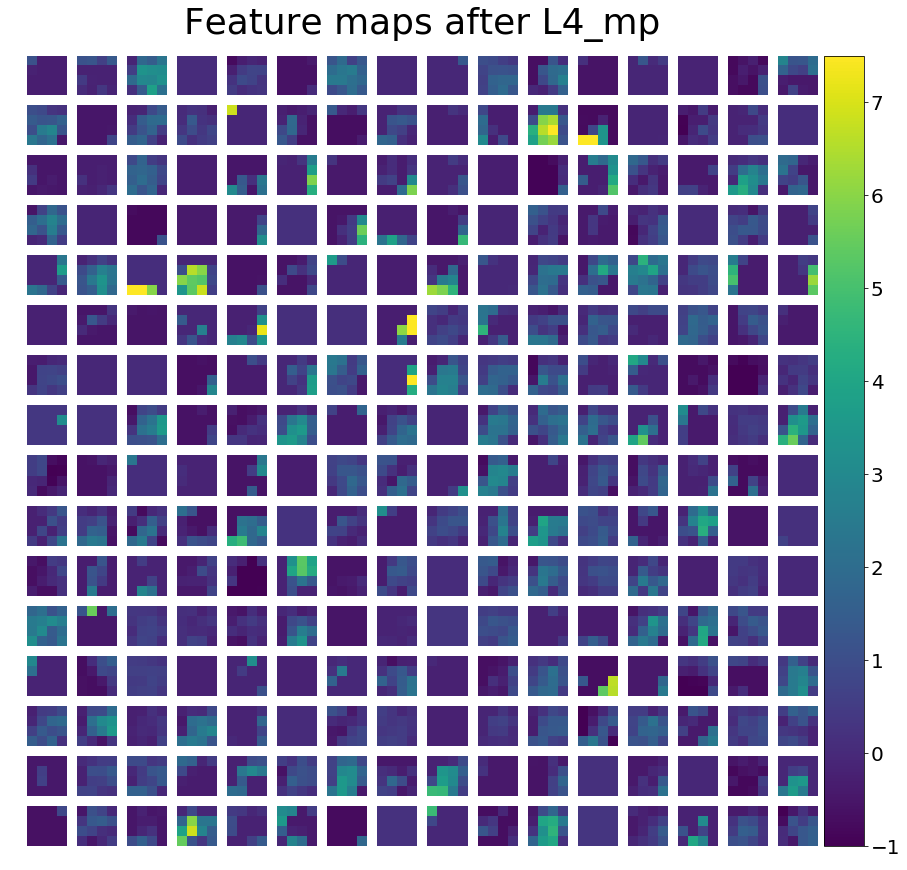

In [25]:
plot_conv_layers(X1)

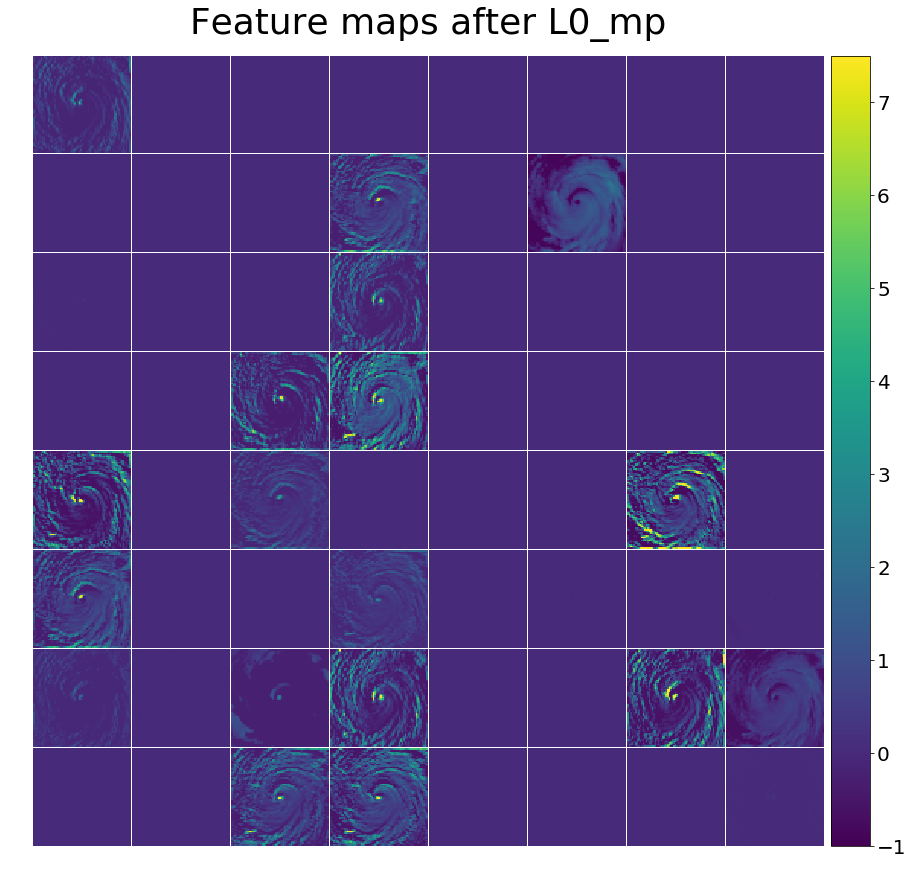

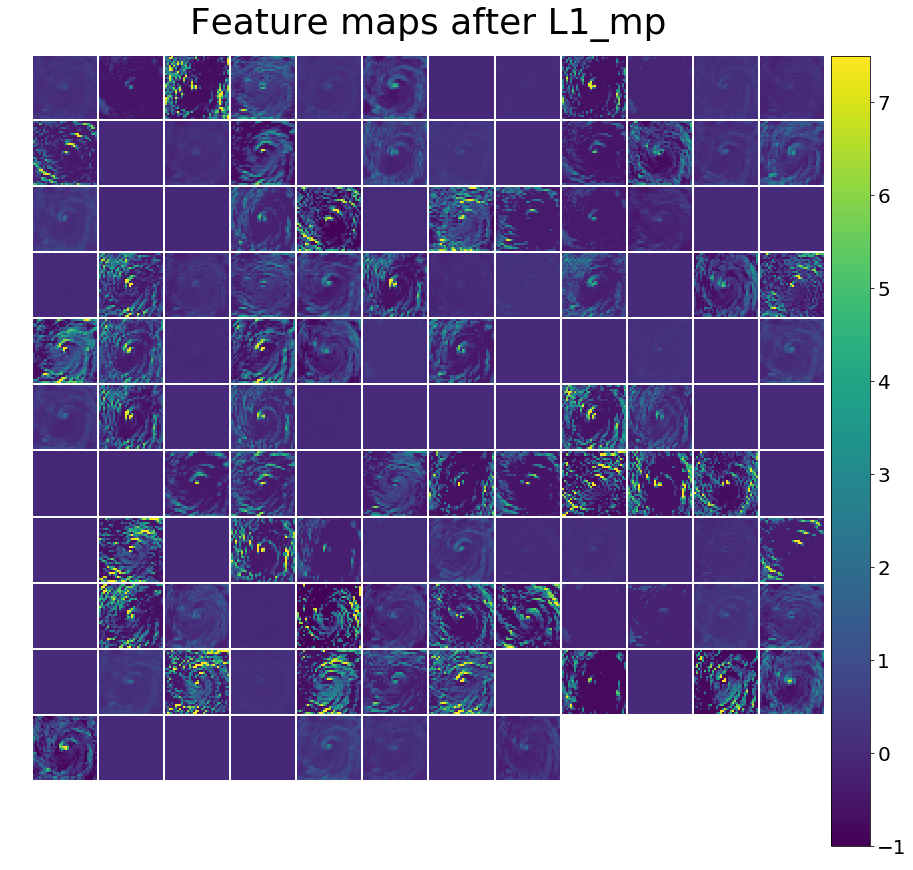

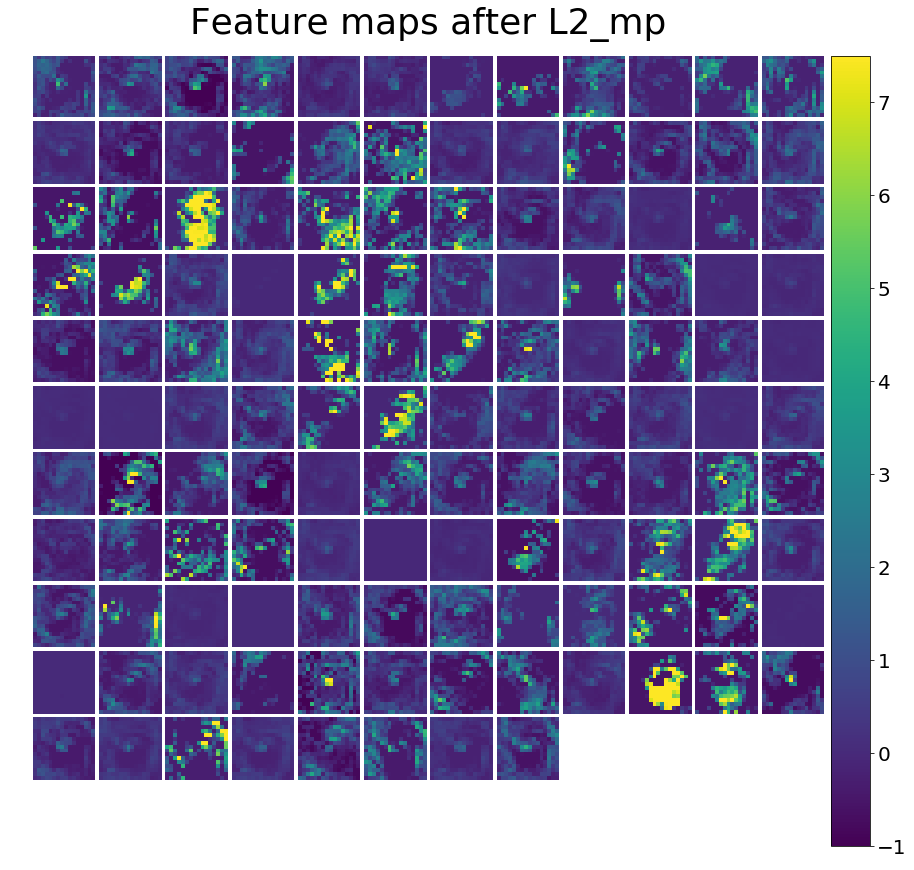

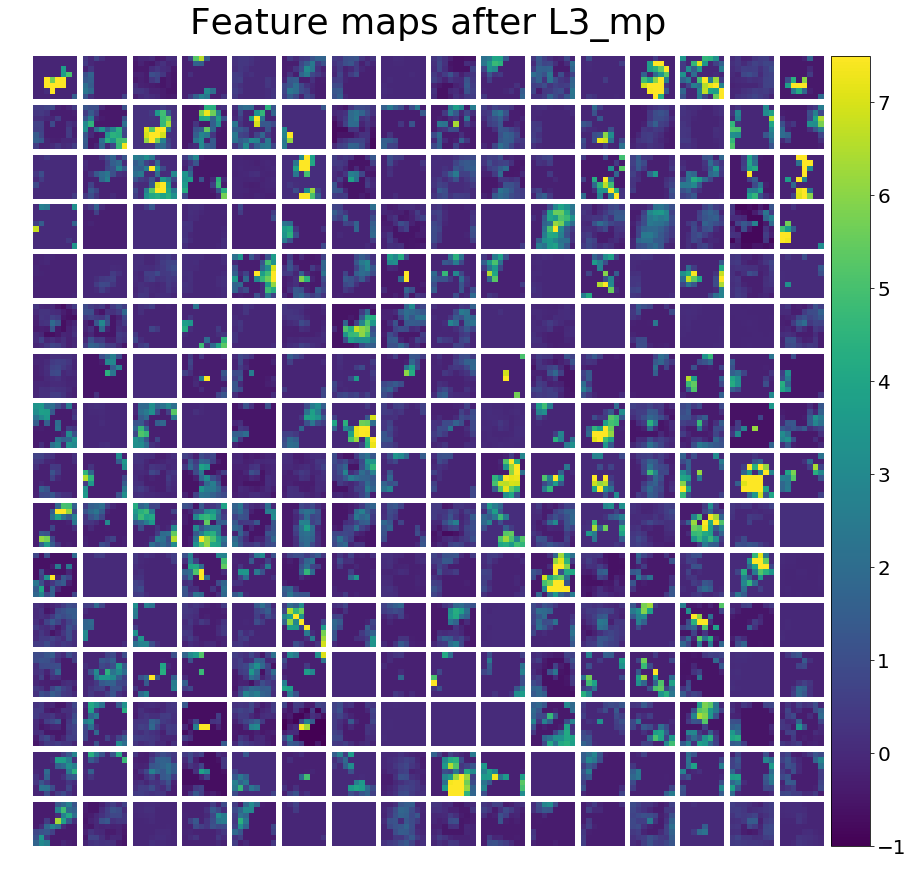

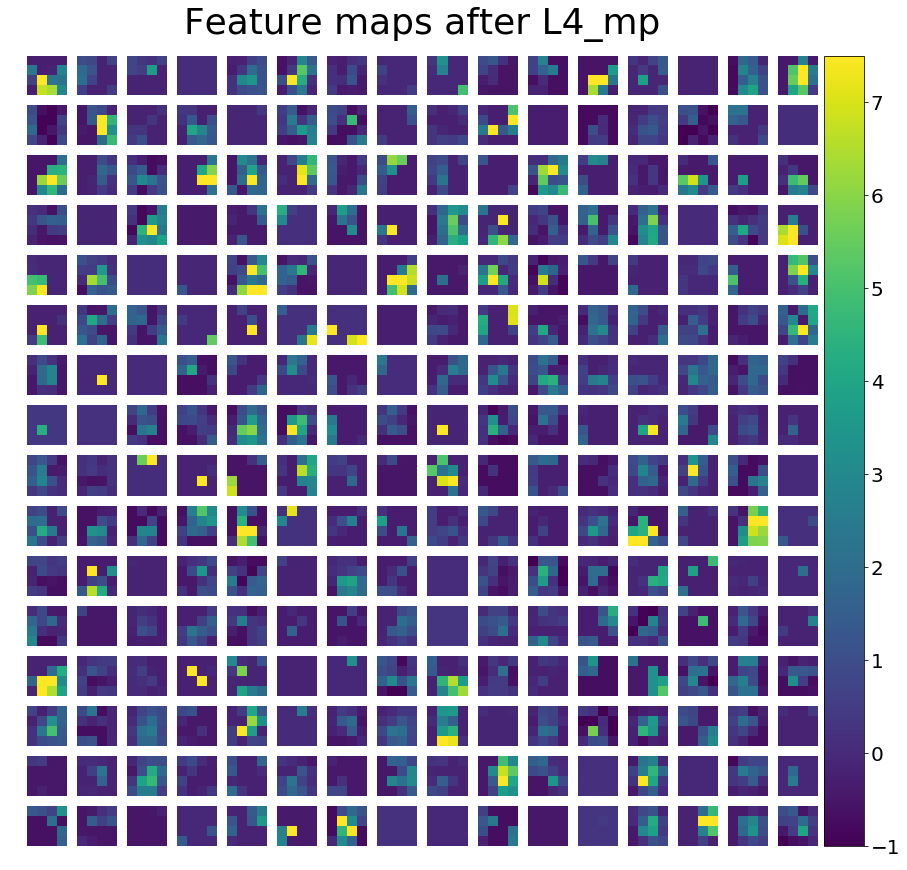

In [26]:
plot_conv_layers(X2)

### 2.2 Dense Layers

### 2.2 Dense layer
Once the conv layers have been explored, we now proceed to inspect the dense layers. To this end, we will try to see which units are activated in the dense layers.

In [36]:
def plot_dense_layers(X):
    C = get_activations(model, 'batch_normalisation_6', X, dense=True, expand=100)
    plt.gcf().clear()
    im = plt.imshow(C)
    plt.colorbar(im)
    plt.axis('off')
    plt.title('Activations after BN_6', fontsize=10, y=1.02)
    # plt.savefig('../_assets/example_activation_l3_tc.eps', format='eps')
    plt.show()

    C = get_activations(model, 'batch_normalisation_7', X, dense=True, expand=20)
    plt.gcf().clear()
    im = plt.imshow(C)
    plt.axis('off')
    plt.colorbar(im)
    plt.title('Activations after BN_7', fontsize=10, y=1.02)
    # plt.savefig('../_assets/example_activation_l4_tc.eps', format='eps')
    plt.show()

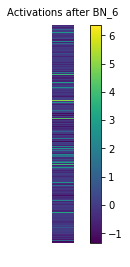

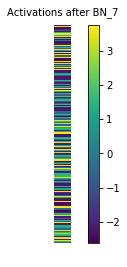

In [37]:
plot_dense_layers(X1)

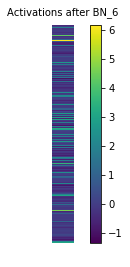

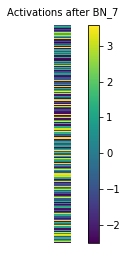

In [38]:
plot_dense_layers(X2)

## 2. Embedding
Here, we explore the possibility of using the last layers of RegNet as an embedding for other tasks. To this end, we use techniques such as PCA or LDA to project the data in low dimensional spaces so as to be able to observe its distribution.